This analysis supports load/demand forecasting; older labels referenced renewables but the model in this notebook predicts electric demand (kW).


In [2]:
!pip install scikit-learn pandas matplotlib seaborn prophet

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached prophet-1.1.7-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached holidays-0.76-py3-none-any.whl.metadata (44 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached prophet-1.1.7-py3-none-win_amd64.whl (13.3 MB)
Using cached cmdstanpy-1.2.5-py3-none-any.whl (94 kB)
Using cached holidays-0.76-py3-none-any.whl (1.1 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_excel(r'E:\renewable-energy-optimization-ai\data\Active Power Load - 33_11KV - Godishala Substation .xlsx')  # Change path/filename as needed
# df['DATE'] = pd.to_datetime(df['DATE'])
# if 'TIME' in df.columns:
#     df['DATETIME'] = pd.to_datetime(df['DATE'].astype(str) + ' ' + df['TIME'].astype(str))
# else:
#     df['DATETIME'] = df['DATE']
# df = df.sort_values('DATETIME')
df.head()


,DATE,TIME,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0
0,2021-01-01,01-00,11.6,102,0.96,1967.388015,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Nov-Feb,Winter,1.0
1,NaT,02-00,11.6,102,0.96,1967.388015,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Mar-Jun,Summer,2.0
2,NaT,03-00,11.6,102,0.96,1967.388015,0,1,65,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,04-00,11.3,130,0.96,2442.607331,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekend,1,NaN
4,NaT,05-00,11.2,148,0.96,2756.205522,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekday,0,NaN


In [6]:
print(df[['DATE', 'TIME']].head(10))
print(df['TIME'].unique()[:10])   # See first 10 unique TIME values


        DATE   TIME
0 2021-01-01  01-00
1        NaT  02-00
2        NaT  03-00
3        NaT  04-00
4        NaT  05-00
5        NaT  06-00
6        NaT  07-00
7        NaT  08-00
8        NaT  09-00
9        NaT  10-00
['01-00' '02-00' '03-00' '04-00' '05-00' '06-00' '07-00' '08-00' '09-00'
 '10-00']


In [7]:
# Make sure DATE is string
df['DATE'] = df['DATE'].astype(str)
# Clean TIME, replace '-' with ':', pad if needed
df['TIME'] = df['TIME'].astype(str).str.replace('-', ':')
df['TIME'] = df['TIME'].str.zfill(5)  # Ensures "2:00" -> "02:00"

# Combine
dt_strings = df['DATE'] + ' ' + df['TIME']

# Now parse to datetime, errors='coerce' will turn bad values into NaT (can drop them)
df['DATETIME'] = pd.to_datetime(dt_strings, errors='coerce')
df = df.dropna(subset=['DATETIME'])
df = df.sort_values('DATETIME')
df.head()


,DATE,TIME,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0,DATETIME
0,2021-01-01,01:00,11.6,102,0.96,1967.388015,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Nov-Feb,Winter,1.0,2021-01-01 01:00:00
24,2021-01-02,01:00,11.7,95,0.95,1828.915749,0,1,65,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-02 01:00:00
48,2021-01-03,01:00,11.8,114,0.96,2236.756556,1,1,65,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-03 01:00:00
72,2021-01-04,01:00,11.8,114,0.97,2260.056104,0,1,68,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-04 01:00:00
96,2021-01-05,01:00,11.7,106,0.96,2062.165835,0,1,66,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-05 01:00:00


In [8]:
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 8736
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE                 365 non-null    object        
 1   TIME                 365 non-null    object        
 2   VOLTAGE              365 non-null    float64       
 3   CURRENT              365 non-null    int64         
 4   PF                   365 non-null    float64       
 5   POWER (KW)           365 non-null    float64       
 6   "WEEKEND/WEEKDAY"    365 non-null    int64         
 7   SEASON               365 non-null    int64         
 8   Temp (F)             365 non-null    int64         
 9   Humidity (%)         365 non-null    int64         
 10  Substation Shutdown  1 non-null      float64       
 11  F1                   0 non-null      float64       
 12  F2                   0 non-null      float64       
 13  F3                   1 non-null      fl

In [11]:
drop_cols = ['Substation Shutdown', 'F1', 'F2', 'F3', 'F4', 'Jul-Oct-', 'Rainy', '0']
df_clean = df.drop(columns=[col for col in drop_cols if col in df.columns])


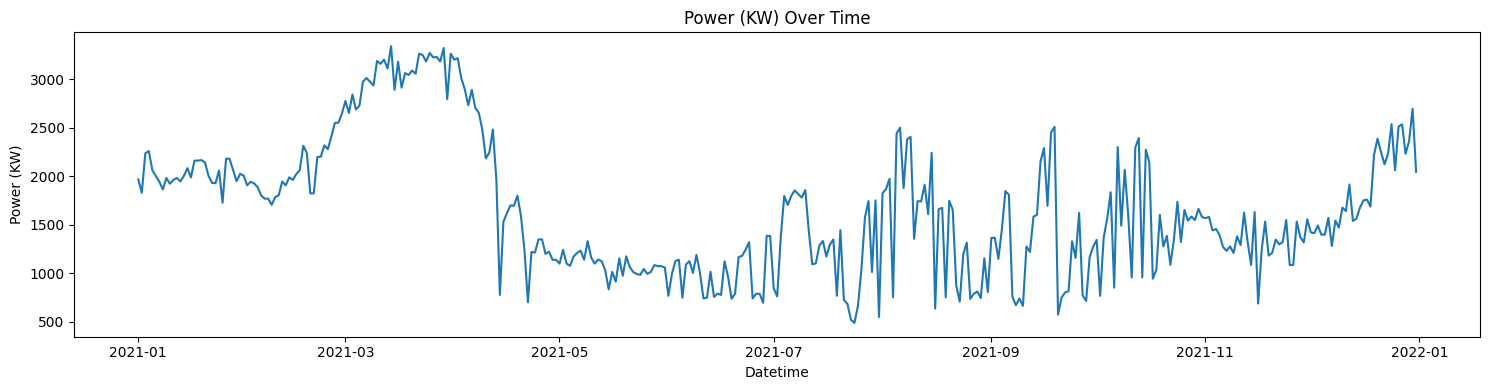

In [12]:
plt.figure(figsize=(15, 4))
plt.plot(df_clean['DATETIME'], df_clean['POWER (KW)'])
plt.title('Power (KW) Over Time')
plt.xlabel('Datetime')
plt.ylabel('Power (KW)')
plt.tight_layout()
plt.show()



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
16:30:10 - cmdstanpy - INFO - Chain [1] start processing
16:30:10 - cmdstanpy - INFO - Chain [1] done processing


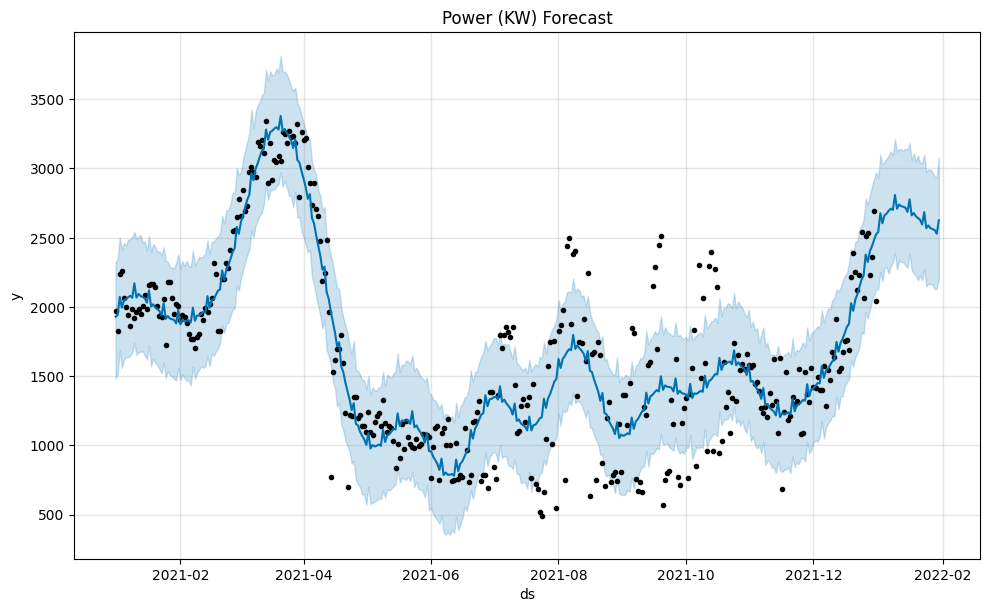

In [13]:
!pip install prophet --quiet
from prophet import Prophet

prophet_df = df_clean[['DATETIME', 'POWER (KW)']].rename(columns={'DATETIME': 'ds', 'POWER (KW)': 'y'}).dropna()
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(prophet_df)
future = model.make_future_dataframe(periods=30, freq='D')  # Forecast next 30 days
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Power (KW) Forecast')
plt.show()


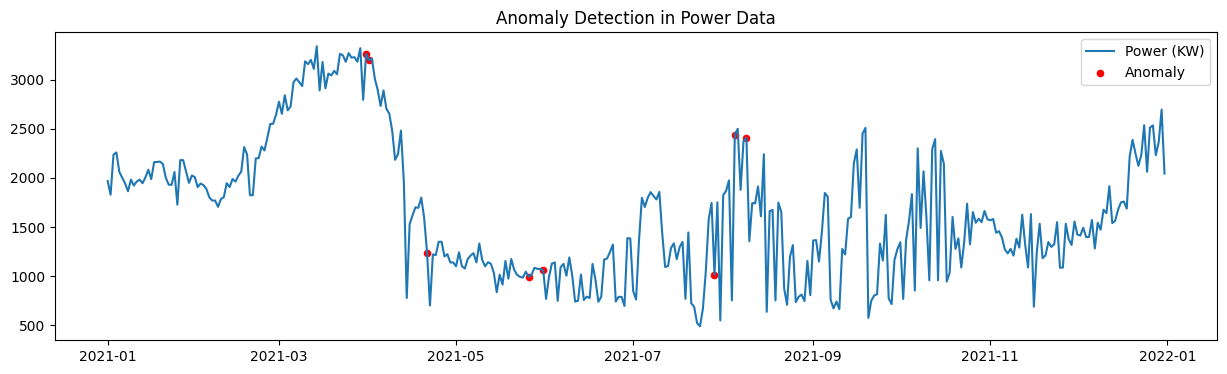

In [14]:
from sklearn.ensemble import IsolationForest

numeric_cols = ['POWER (KW)', 'VOLTAGE', 'CURRENT', 'PF', 'Temp (F)', 'Humidity (%)']
features = df_clean[numeric_cols].fillna(0)
iso = IsolationForest(contamination=0.02, random_state=42)
df_clean['anomaly'] = iso.fit_predict(features)

# Plot anomalies
plt.figure(figsize=(15, 4))
plt.plot(df_clean['DATETIME'], df_clean['POWER (KW)'], label='Power (KW)')
plt.scatter(
    df_clean[df_clean['anomaly'] == -1]['DATETIME'],
    df_clean[df_clean['anomaly'] == -1]['POWER (KW)'],
    color='red', label='Anomaly', s=20
)
plt.legend()
plt.title('Anomaly Detection in Power Data')
plt.show()


In [15]:
# Prepare your dataframe for Prophet
prophet_df = df_clean[['DATETIME', 'POWER (KW)']].rename(columns={'DATETIME': 'ds', 'POWER (KW)': 'y'}).dropna()

# Initialize and train the model (this is the training step!)
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(prophet_df)


16:30:20 - cmdstanpy - INFO - Chain [1] start processing
16:30:21 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)


Mean Absolute Error (MAE): 228.27
Root Mean Squared Error (RMSE): 320.38


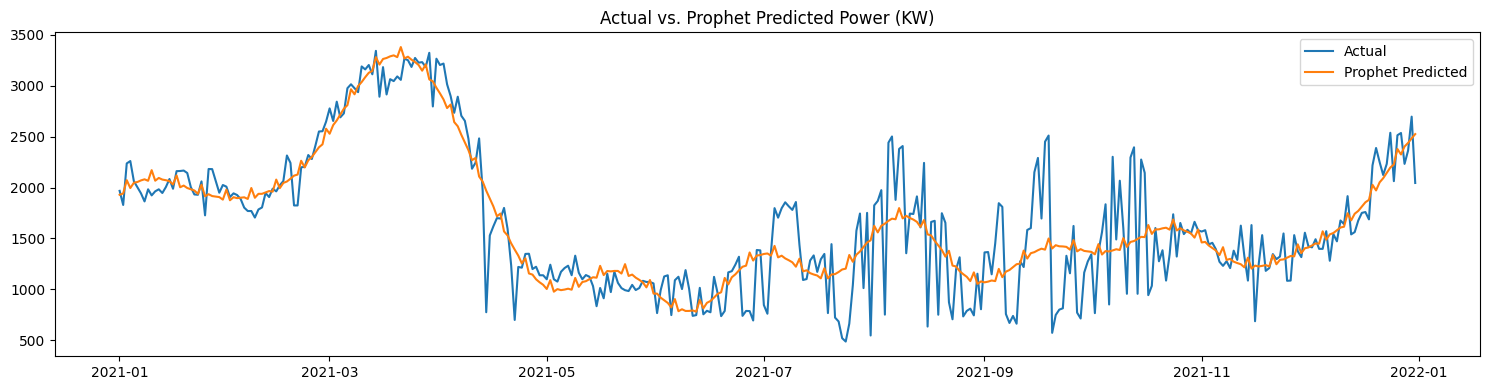

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict only for the time range of your actual data
forecast_in_sample = model.predict(prophet_df[['ds']])

# Compare predicted vs. actual
y_true = prophet_df['y'].values
y_pred = forecast_in_sample['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot Actual vs. Predicted
plt.figure(figsize=(15,4))
plt.plot(prophet_df['ds'], y_true, label='Actual')
plt.plot(prophet_df['ds'], y_pred, label='Prophet Predicted')
plt.legend()
plt.title('Actual vs. Prophet Predicted Power (KW)')
plt.tight_layout()
plt.show()


In [18]:
df_xgb = df_clean.copy()
df_xgb = df_xgb.sort_values('DATETIME')

# Date parts
df_xgb['hour'] = df_xgb['DATETIME'].dt.hour
df_xgb['dayofweek'] = df_xgb['DATETIME'].dt.dayofweek
df_xgb['month'] = df_xgb['DATETIME'].dt.month

# Lag features (just lag1)
df_xgb['lag1'] = df_xgb['POWER (KW)'].shift(1)
# Rolling mean features (just window=3)
df_xgb['rolling_mean_3'] = df_xgb['POWER (KW)'].rolling(window=3).mean()

# Drop only NA from lag1 and rolling_mean_3
df_xgb = df_xgb.dropna(subset=['lag1', 'rolling_mean_3']).reset_index(drop=True)
df_xgb.head()


,DATE,TIME,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),0,DATETIME,anomaly,hour,dayofweek,month,lag1,rolling_mean_3
0,2021-01-03,01:00,11.8,114,0.96,2236.756556,1,1,65,92,NaN,2021-01-03 01:00:00,1,1,6,1,1828.915749,2011.020107
1,2021-01-04,01:00,11.8,114,0.97,2260.056104,0,1,68,88,NaN,2021-01-04 01:00:00,1,1,0,1,2236.756556,2108.576136
2,2021-01-05,01:00,11.7,106,0.96,2062.165835,0,1,66,90,NaN,2021-01-05 01:00:00,1,1,1,1,2260.056104,2186.326165
3,2021-01-06,01:00,11.6,106,0.94,2001.945893,0,1,73,86,NaN,2021-01-06 01:00:00,1,1,2,1,2062.165835,2108.055944
4,2021-01-07,01:00,11.8,97,0.98,1942.855247,0,1,71,89,NaN,2021-01-07 01:00:00,1,1,3,1,2001.945893,2002.322325


In [19]:
print("Data shape after feature engineering:", df_xgb.shape)

split_idx = int(0.9 * len(df_xgb))  # try 90% train
train = df_xgb.iloc[:split_idx]
test = df_xgb.iloc[split_idx:]

print("Train size:", train.shape)
print("Test size:", test.shape)


Data shape after feature engineering: (363, 18)
Train size: (326, 18)
Test size: (37, 18)


In [20]:
feature_cols = [
    'VOLTAGE', 'CURRENT', 'PF', 'Temp (F)', 'Humidity (%)',
    '"WEEKEND/WEEKDAY"', 'SEASON',
    'lag1', 'rolling_mean_3'
]
target_col = 'POWER (KW)'

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]


In [21]:
!pip install xgboost --quiet
import xgboost as xgb

model_xgb = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_xgb.fit(X_train, y_train)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


XGBoost MAE: 56.97
XGBoost RMSE: 82.49


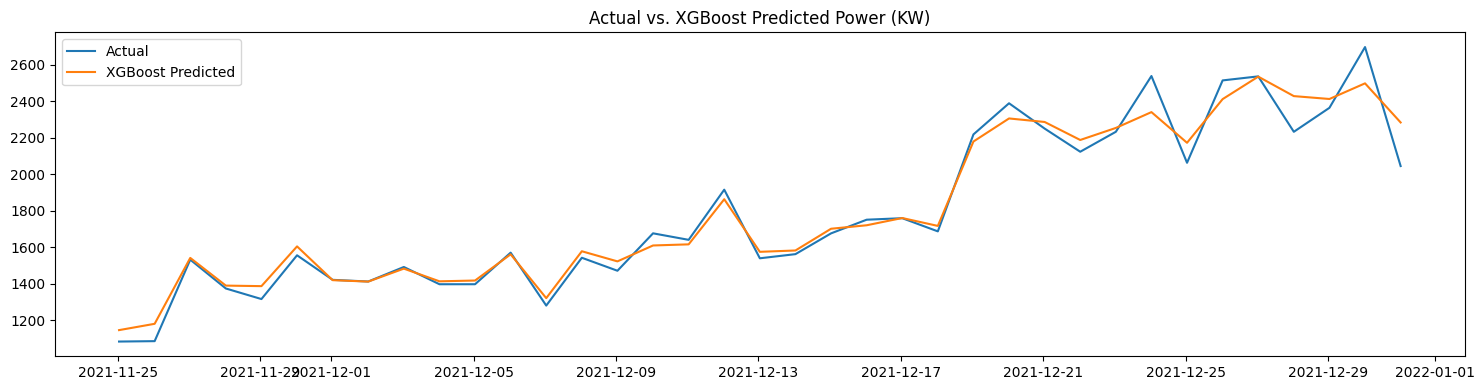

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

y_pred_xgb = model_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")

plt.figure(figsize=(15,4))
plt.plot(test['DATETIME'], y_test, label='Actual')
plt.plot(test['DATETIME'], y_pred_xgb, label='XGBoost Predicted')
plt.legend()
plt.title('Actual vs. XGBoost Predicted Power (KW)')
plt.tight_layout()
plt.show()


In [29]:
mape = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 3.04%


In [30]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred_xgb)
print(f"R² Score: {r2:.3f} ({r2*100:.1f}%)")


R² Score: 0.964 (96.4%)


In [31]:
# MAPE
mape = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# R² Score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_xgb)
print(f"R² Score: {r2:.3f} ({r2*100:.1f}%)")


Mean Absolute Percentage Error (MAPE): 3.04%
R² Score: 0.964 (96.4%)


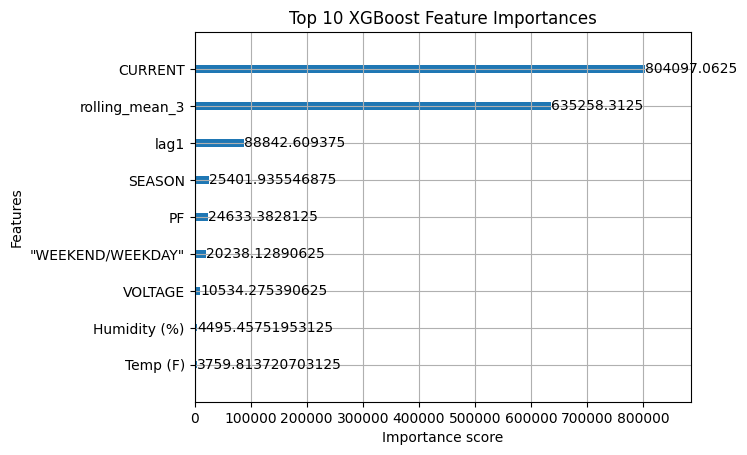

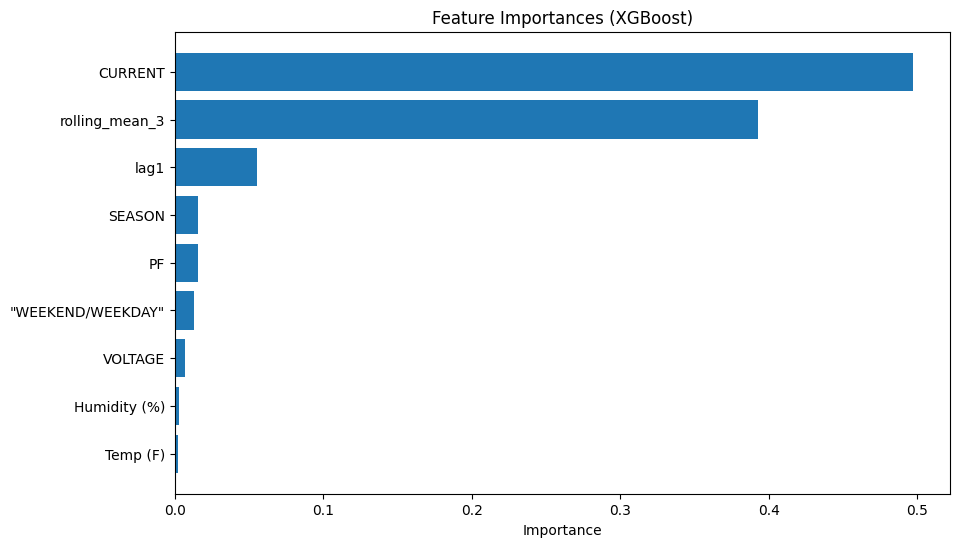

In [32]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot built-in feature importance
xgb.plot_importance(model_xgb, importance_type='gain', max_num_features=10)
plt.title('Top 10 XGBoost Feature Importances')
plt.show()

# If you want a pretty seaborn plot:
importances = model_xgb.feature_importances_
feat_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.show()


In [34]:
import pickle
import os

os.makedirs(r'E:\renewable-energy-optimization-ai\ml\models', exist_ok=True)
with open(r'E:\renewable-energy-optimization-ai\ml\models\xgboost_model.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)


In [35]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb

# Define parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}


In [36]:
tscv = TimeSeriesSplit(n_splits=5)  # Keeps order, good for time series


In [37]:
xgb_reg = xgb.XGBRegressor(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.05, 0.1, ...], 'max_depth': [3, 4, ...], 'n_estimators': [50, 100, ...], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [38]:
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Score (MAE):", -grid_search.best_score_)


Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV Score (MAE): 143.6616422938279


In [39]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mape_best = np.mean(np.abs((y_test - y_pred_best) / y_test)) * 100
r2_best = r2_score(y_test, y_pred_best)

print(f"MAE (best): {mae_best:.2f}")
print(f"RMSE (best): {rmse_best:.2f}")
print(f"MAPE (best): {mape_best:.2f}%")
print(f"R² Score (best): {r2_best:.3f} ({r2_best*100:.1f}%)")


MAE (best): 48.77
RMSE (best): 81.58
MAPE (best): 2.46%
R² Score (best): 0.965 (96.5%)


In [41]:
import pickle
with open(r'E:\renewable-energy-optimization-ai\ml\models\xgboost_best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Tuned model saved as xgboost_best_model.pkl")


Tuned model saved as xgboost_best_model.pkl


In [42]:
!pip install mlflow --quiet


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
# Inside your XGBoost training/tuning notebook
import mlflow
import mlflow.sklearn

mlflow.set_experiment("energy-forecast-xgboost")

with mlflow.start_run(run_name="xgboost-tuned"):
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("mae", mae_best)
    mlflow.log_metric("rmse", rmse_best)
    mlflow.log_metric("mape", mape_best)
    mlflow.log_metric("r2", r2_best)
    mlflow.sklearn.log_model(best_model, "model")
    print("Logged run to MLflow")


2025/07/18 16:36:07 INFO mlflow.tracking.fluent: Experiment with name 'energy-forecast-xgboost' does not exist. Creating a new experiment.
2025/07/18 16:36:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/18 16:36:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged run to MLflow
